# Model evaluation utilities

In [ ]:
#| default_exp ml.evaluation

In [ ]:
#| hide
from fastcore.test import *
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from fastcore.basics import ifnone

In [ ]:
#| export
def find_binary_clf_threshold(targets, preds, metrics, *, threshold_range=None, weight=None, metric_names=None, show=True):
    """Find the best threshold for binary classification given targets and predicted probabilities"""
    if weight is None:
        weight = [1.0] * len(metrics)
    if threshold_range is None:
        threshold_range = np.arange(0, 1, 0.05)
    weight = (np.array(weight) / np.sum(weight)).reshape(len(metrics), -1)
    scores = np.array([
        [metric(targets, preds > threshold) for threshold in threshold_range]
        for metric in metrics
    ])
    wavg_scores = (scores * weight).sum(axis=0)
    best_idx = wavg_scores.argmax()
    best_threshold =  threshold_range[best_idx]
    best_score =  wavg_scores[best_idx]

    if show:
        import matplotlib.pyplot as plt
        if metric_names is None:
            metric_names = [None]*len(metrics)
        metric_names = [
            ifnone(name, ifnone(getattr(metric, '__name__', None), f"Metric - {i}")) 
            for i, (metric, name) in enumerate(zip(metrics, metric_names))
        ]
        fig = plt.figure(figsize=(8, 4))
        plt.plot(threshold_range, scores.T, label=metric_names)
        plt.plot(threshold_range, wavg_scores.T, label='Weighted avg', linewidth=2)
        plt.plot([best_threshold], [best_score], 'ro')
        plt.axvline(x=best_threshold, color='gray', linestyle='--')
        plt.legend(loc='best')
        plt.show()
    
    return best_threshold

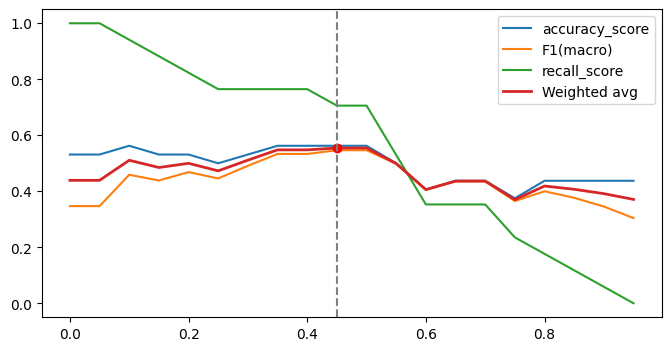

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from functools import partial

f1_macro = partial(f1_score, average='macro')

bs = 32
preds = np.random.rand(bs)
targets = np.random.randint(0, 2, bs)
threshold = find_binary_clf_threshold(
    targets, 
    preds, 
    [accuracy_score, f1_macro, recall_score], 
    weight=[0.5, 0.5, 0], 
    metric_names=[None, 'F1(macro)', None]
)

In [ ]:
#| hide
preds = np.array([0.6, 0.3, 0.5, 0.9, 0.8, 0.2, 0.55, 0.77])
targets = np.array([1,0,0,1,1,0,1,1])
thresh = find_binary_clf_threshold(targets, preds, [accuracy_score], show=False)
test_close(thresh, 0.5)

In [ ]:
#| export
from sklearn.metrics import classification_report
from fastai.metrics import F1Score, accuracy

def evaluate_slmc(learn, dl, class_names, show=True):
    probs, targets, preds = learn.get_preds(dl=dl, with_decoded=True)
    clf_report = classification_report(
        targets.cpu().numpy(),
        preds.cpu().numpy(),
        labels=list(range(len(class_names))),
        target_names=class_names
    )
    label_indices = list(range(len(class_names)))
    if show:
        from sklearn.metrics import ConfusionMatrixDisplay
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(16, 12))
        ConfusionMatrixDisplay.from_predictions(
            targets, 
            preds, 
            labels=label_indices, 
            display_labels=class_names, 
            ax=ax
        )
    scores = dict(
        f1_macro = F1Score(average='macro')(preds, targets).item(),
        accuracy = accuracy(probs, targets).item(),
    )
    return clf_report, scores

              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         0
         dog       1.00      1.00      1.00         1
         fox       0.00      0.00      0.00         0
         cow       0.00      0.00      0.00         0
       snake       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00         1
   macro avg       0.20      0.20      0.20         1
weighted avg       1.00      1.00      1.00         1



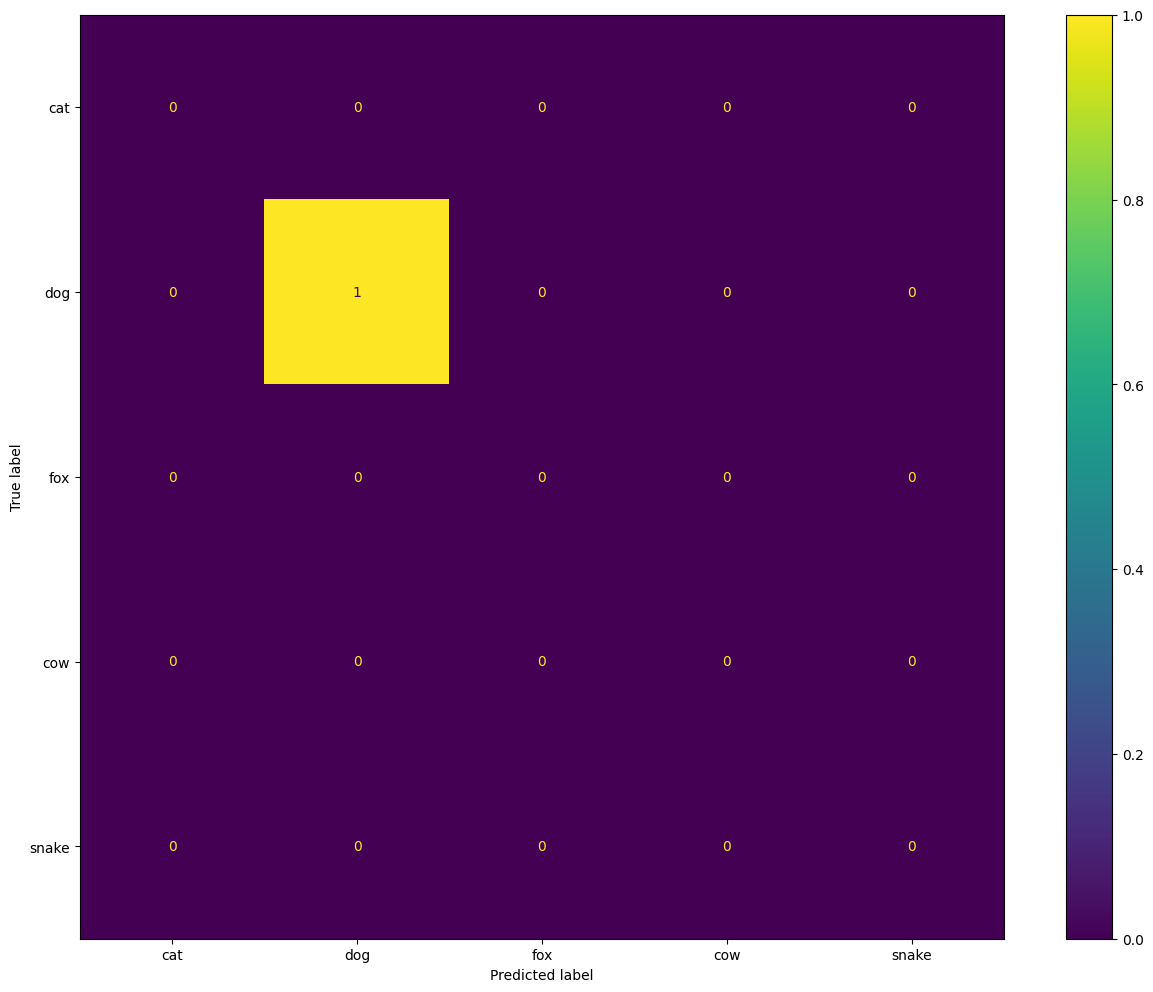

In [ ]:
import torch
from unittest.mock import Mock

n_cls = 5

targets = torch.tensor([[1]])
probs = torch.tensor([[0.1, 0.5, 0.1, 0.1, 0.2]])
preds = probs.argmax().unsqueeze(0)

learn = Mock()
learn.get_preds.return_value = probs, targets, preds
clf_report, scores = evaluate_slmc(learn, None, ['cat', 'dog', 'fox', 'cow', 'snake'])
test_eq(scores['f1_macro'], 1.0)
test_eq(scores['accuracy'], 1.0)
print(clf_report)
